# Single image training

For testing purposes and to see how well the regular encoding works on the lightfield images, we use a regular autoencoder. The basic model is the one proposed in this tutorial from PyTorch:
    https://github.com/udacity/deep-learning-v2-pytorch/tree/master/autoencoder/convolutional-autoencoder

In [1]:
# Imports and dataloading as usual
import os
from dataloaders import hci4d, lfsequence
import torch
from torch import optim
import lightfield_vae as vae
from utils import show_view_sequence
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision import transforms
from matplotlib import pyplot as plt

DATA_ROOT = os.path.join('data', 'SyntheticLightfieldData')
BATCH_SIZE = 6
use_cuda = torch.cuda.is_available()
print("Use cuda:", use_cuda)
kwargs = {'num_workers': 64, 'pin_memory': True} if use_cuda else {}

## Create multiple train sets to increase the training data
train_set1 = lfsequence.LFSequence(os.path.join(DATA_ROOT, 'training'),
                                   transform=hci4d.Crop((128, 128), (128,128)), length=27)
train_set2 = lfsequence.LFSequence(os.path.join(DATA_ROOT, 'training'), 
                                   transform=hci4d.Crop((128, 128), (128,256)), length=27)
train_set3 = lfsequence.LFSequence(os.path.join(DATA_ROOT, 'training'), 
                                   transform=hci4d.Crop((128, 128), (256,128)), length=27)
train_set4 = lfsequence.LFSequence(os.path.join(DATA_ROOT, 'training'), 
                                   transform=hci4d.Crop((128, 128), (256,256)), length=27)
test_set = lfsequence.LFSequence(os.path.join(DATA_ROOT, 'test'),transform=hci4d.CenterCrop(128))
print("Training set length:", 4 * len(train_set1))
print("Test set length:", len(test_set))
device = torch.device("cuda:0" if use_cuda else "cpu")

# Dataloaders
train_loader1 = DataLoader(train_set1, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
train_loader2 = DataLoader(train_set2, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
train_loader3 = DataLoader(train_set3, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
train_loader4 = DataLoader(train_set4, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

n_train = 4 * len(train_loader1.dataset)
n_test = len(test_loader.dataset)
print("Data samples for training:", n_train)
print("Data samples for testing:", n_test)

Use cuda: True
Training set length: 108
Test set length: 2
Data samples for training: 108
Data samples for testing: 2


## Standard VAE
This autoencoder architecture was taken as it is from PyTorch's autoencoder tutorial. We take this to compare our own precision

In [9]:
# define the NN architecture (copied from the tutorial)
from torch import nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        print(x.shape)
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x, False, False

# initialize the NN
model = ConvAutoencoder()
model.to(device)
print(model)

# Optimizer and loss
def loss_function(recon_x, x, mu, logvar):
    return F.mse_loss(recon_x, x)
optimizer = optim.Adam(model.parameters(), lr=0.001)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


## Own autoencoder architecture
We alterate the regular architecture more and more with the goal to improve the results. If we archieve a very good result, we take this architecture for the one we train the sequences on

In [7]:
from torch.nn import functional as F
import torch
from torch import nn
import numpy as np

DENSE_DIM = (1024, 7, 7)
DENSE_SIZE = np.prod(DENSE_DIM)


class VAE(nn.Module):
    """
    Basic VAE from the pytorch examples
    """
    def __init__(self, bottleneck=2048, dims=(9, 3, 512, 512)):
        super(VAE, self).__init__()
        self.dims = dims
        self.channels = dims[0]
        self.width = dims[1]
        self.height = dims[2]

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=self.channels, out_channels=128, kernel_size=4, stride=2),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2), 
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2), 
            nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=2), 
            nn.BatchNorm2d(1024), nn.ReLU()
        )
        #self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2),
            nn.BatchNorm2d(512), nn.ReLU(),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2),
            nn.BatchNorm2d(256) , nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=self.channels, kernel_size=4, stride=2), nn.Sigmoid()
        )
        #self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.mu_layer = nn.Linear(DENSE_SIZE, bottleneck)
        self.var_layer = nn.Linear(DENSE_SIZE, bottleneck)
        self.z_layer = nn.Linear(bottleneck, DENSE_SIZE)

        self.unpool_idx = None

    def encode(self, x):
        x = x.view(-1, self.channels, self.width, self.height)
        conv = self.encoder(x)
        print(conv.shape)
        #pool, idx = self.pool(conv)
        #self.unpool_idx = idx
        #print(pool.shape)
        h1 = conv.view(-1, DENSE_SIZE)
        return self.mu_layer(h1), self.var_layer(h1)
        #return pool

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return mu + eps*std
        return mu

    def decode(self, z):
        h3 = self.z_layer(z).view(-1, *DENSE_DIM)
        #print(h3.shape)
        #unpool = self.unpool(h3, self.unpool_idx)
        dec = self.decoder(h3)
        print(dec.shape)
        return dec.view(-1, *self.dims)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
        #return self.decode(self.encode(x)), False, False


def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    #KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return BCE #+ KLD


# initialize the NN
model = VAE(dims=(3, 128, 128))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print(model)


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(256

## Autoencoder already used on lightfields

This autoencoder architecture was used already on lightfield data. Here, we remodeled it to a VAE

In [7]:
from torch.nn import functional as F
import torch
from torch import nn
import numpy as np


class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, transpose=False):
        super(ResidualBlock, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.lr = nn.LeakyReLU()
        if transpose:
            self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
            self.conv2 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
    
    def forward(self, x):
        normed = self.bn(x)
        return self.lr(self.conv1(normed)) + self.conv2(normed)

    
class Encoder(nn.Module):
    
    def __init__(self, channels):
        super(Encoder, self).__init__()
        self.grp1 = nn.Sequential(
            ResidualBlock(channels, 16),
            ResidualBlock(16, 32),
            ResidualBlock(32, 64, 4, 2), # 128 x 61 x61
        )
        '''
        self.grp2 = nn.Sequential(
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 256, 3, 2) # 256 x 28 x 28
        )
        self.grp3 = nn.Sequential(
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 512, 4, 2) # 512 x 11 x 11
        )
        
        self.grp4 = nn.Sequential(
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            ResidualBlock(512, 1024, 3, 2) # 1024 x 3 x 3
        )
        '''
    
    def forward(self, x):
        x1 = self.grp1(x)
        return x1
        '''
        #print(x1.shape)
        x2 = self.grp2(x1)
        #print(x2.shape)
        x3 = self.grp3(x2)
        #print(x3.shape)
        x4 = self.grp4(x3)
        #print(x4.shape)
        return x4
        '''
    
class Decoder(nn.Module):
    
    def __init__(self, channels):
        super(Decoder, self).__init__()
        self.grp1 = nn.Sequential(
            ResidualBlock(64, 32, 4, 2, transpose=True),
            ResidualBlock(32, 16, transpose=True),
            ResidualBlock(16, channels, transpose=True)
        )
        '''
        self.grp2 = nn.Sequential(
            ResidualBlock(512, 256, 4, 2, transpose=True),
            ResidualBlock(256, 256, transpose=True),
            ResidualBlock(256, 256, transpose=True)
        )
        
        self.grp3 = nn.Sequential(
            ResidualBlock(256, 128, 3, 2, transpose=True),
            ResidualBlock(128, 128, transpose=True),
            ResidualBlock(128, 128, transpose=True)
        )
        self.grp4 = nn.Sequential(
            ResidualBlock(128, channels, 4, 2, transpose=True),
            ResidualBlock(channels, channels, transpose=True),
            ResidualBlock(channels, channels, transpose=True)
        )
        '''
        #self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        x1 = self.grp1(x)
        return x1
        '''
        #print(x1.shape)
        x2 = self.grp2(x1)
        #print(x2.shape)
        x3 = self.grp3(x2)
        #print(x3.shape)
        x4 = self.grp4(x3)
        #print(x4.shape)
        return self.sigmoid(x4)
        '''

DENSE_DIM = (64, 30, 30)
DENSE_SIZE = np.prod(DENSE_DIM)


class VAE(nn.Module):
    def __init__(self, bottleneck=2048, dims=(9, 3, 512, 512)):
        super(VAE, self).__init__()
        self.dims = dims
        self.channels = dims[0]
        self.width = dims[1]
        self.height = dims[2]

        self.encoder = Encoder(self.channels)
        self.decoder = Decoder(self.channels)
        self.mu_layer = nn.Conv2d(64, 64, 3, 2) # 64 x 30 x 30
        self.var_layer = nn.Conv2d(64, 64, 3, 2)
        self.z_layer = nn.ConvTranspose2d(64, 64, 3, 2)


    def encode(self, x):
        x = x.view(-1, self.channels, self.width, self.height)
        h1 = self.encoder(x)
        return self.mu_layer(h1).view(-1, DENSE_SIZE), self.var_layer(h1).view(-1, DENSE_SIZE)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return mu + eps*std
        return mu

    def decode(self, z):
        h3 = self.z_layer(z.view(-1, *DENSE_DIM))
        dec = self.decoder(h3)
        return dec.view(-1, *self.dims)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    
def loss_function(recon_x, x, mu, logvar):
    #recon = F.binary_cross_entropy(recon_x, x, reduction='sum')
    recon = F.l1_loss(recon_x, x, reduction="sum")

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return 0.9 * recon + 0.1* KLD

model = VAE(dims=(3, 128, 128))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print(model)

VAE(
  (encoder): Encoder(
    (grp1): Sequential(
      (0): ResidualBlock(
        (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (lr): LeakyReLU(negative_slope=0.01)
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): ResidualBlock(
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (lr): LeakyReLU(negative_slope=0.01)
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): ResidualBlock(
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (lr): LeakyReLU(negative_slope=0.01)
        (conv1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      )
    )
  )
  (decoder): Decoder(

## Training the encoder
We need two training routines, one for each encoder. They are equivalent, though, but the return values are a bit different.

Training with Loader  1
Train Epoch: 1 [0/27 (0%)]	Loss: 54759.135417
Train Epoch: 1 [18/27 (60%)]	Loss: 51023.666667
====> Epoch: 1 Average loss: 52316.8299
Training with Loader  1
Train Epoch: 2 [0/27 (0%)]	Loss: 48705.041667
Train Epoch: 2 [18/27 (60%)]	Loss: 45289.541667
====> Epoch: 2 Average loss: 46854.1481
Training with Loader  1
Train Epoch: 3 [0/27 (0%)]	Loss: 42817.023438
Train Epoch: 3 [18/27 (60%)]	Loss: 39417.286458
====> Epoch: 3 Average loss: 40997.6201
Training with Loader  1
Train Epoch: 4 [0/27 (0%)]	Loss: 37366.869792
Train Epoch: 4 [18/27 (60%)]	Loss: 32126.838542
====> Epoch: 4 Average loss: 34643.4525
Training with Loader  1
Train Epoch: 5 [0/27 (0%)]	Loss: 30741.809896
Train Epoch: 5 [18/27 (60%)]	Loss: 27682.815104
====> Epoch: 5 Average loss: 28795.6212
Training with Loader  1
Train Epoch: 6 [0/27 (0%)]	Loss: 24935.343750
Train Epoch: 6 [18/27 (60%)]	Loss: 22880.263021
====> Epoch: 6 Average loss: 24152.7627
Training with Loader  1
Train Epoch: 7 [0/27 (0%)]	L

====> Epoch: 52 Average loss: 6134.2717
Training with Loader  1
Train Epoch: 53 [0/27 (0%)]	Loss: 5738.432292
Train Epoch: 53 [18/27 (60%)]	Loss: 5550.671224
====> Epoch: 53 Average loss: 6117.6965
Training with Loader  1
Train Epoch: 54 [0/27 (0%)]	Loss: 6404.087891
Train Epoch: 54 [18/27 (60%)]	Loss: 6058.590495
====> Epoch: 54 Average loss: 6175.2254
Training with Loader  1
Train Epoch: 55 [0/27 (0%)]	Loss: 5664.552734
Train Epoch: 55 [18/27 (60%)]	Loss: 6871.716146
====> Epoch: 55 Average loss: 6423.6126
Training with Loader  1
Train Epoch: 56 [0/27 (0%)]	Loss: 6927.300781
Train Epoch: 56 [18/27 (60%)]	Loss: 6661.131510
====> Epoch: 56 Average loss: 6282.5076
Training with Loader  1
Train Epoch: 57 [0/27 (0%)]	Loss: 6357.432292
Train Epoch: 57 [18/27 (60%)]	Loss: 5672.016276
====> Epoch: 57 Average loss: 6342.7894
Training with Loader  1
Train Epoch: 58 [0/27 (0%)]	Loss: 5797.608073
Train Epoch: 58 [18/27 (60%)]	Loss: 6157.263021
====> Epoch: 58 Average loss: 5771.4871
Training wit

====> Epoch: 4 Average loss: 4865.6390
Training with Loader  2
Train Epoch: 5 [0/27 (0%)]	Loss: 4435.444661
Train Epoch: 5 [18/27 (60%)]	Loss: 4614.174805
====> Epoch: 5 Average loss: 4908.3355
Training with Loader  2
Train Epoch: 6 [0/27 (0%)]	Loss: 4457.579427
Train Epoch: 6 [18/27 (60%)]	Loss: 4838.652995
====> Epoch: 6 Average loss: 4714.4264
Training with Loader  2
Train Epoch: 7 [0/27 (0%)]	Loss: 4774.335286
Train Epoch: 7 [18/27 (60%)]	Loss: 5195.675781
====> Epoch: 7 Average loss: 5075.0090
Training with Loader  2
Train Epoch: 8 [0/27 (0%)]	Loss: 5109.053060
Train Epoch: 8 [18/27 (60%)]	Loss: 4279.651042
====> Epoch: 8 Average loss: 4845.4575
Training with Loader  2
Train Epoch: 9 [0/27 (0%)]	Loss: 4251.346680
Train Epoch: 9 [18/27 (60%)]	Loss: 4888.397786
====> Epoch: 9 Average loss: 4741.8518
Training with Loader  2
Train Epoch: 10 [0/27 (0%)]	Loss: 4149.479818
Train Epoch: 10 [18/27 (60%)]	Loss: 4920.118164
====> Epoch: 10 Average loss: 4626.3764
Training with Loader  2
Trai

====> Epoch: 56 Average loss: 4103.9599
Training with Loader  2
Train Epoch: 57 [0/27 (0%)]	Loss: 3819.948568
Train Epoch: 57 [18/27 (60%)]	Loss: 4980.072266
====> Epoch: 57 Average loss: 4463.4575
Training with Loader  2
Train Epoch: 58 [0/27 (0%)]	Loss: 4889.770833
Train Epoch: 58 [18/27 (60%)]	Loss: 4055.265951
====> Epoch: 58 Average loss: 4595.7971
Training with Loader  2
Train Epoch: 59 [0/27 (0%)]	Loss: 4110.571615
Train Epoch: 59 [18/27 (60%)]	Loss: 4387.172852
====> Epoch: 59 Average loss: 4457.2888
Training with Loader  2
Train Epoch: 60 [0/27 (0%)]	Loss: 4101.942383
Train Epoch: 60 [18/27 (60%)]	Loss: 4197.153646
====> Epoch: 60 Average loss: 4276.2142
Training with Loader  2
Train Epoch: 61 [0/27 (0%)]	Loss: 4214.600260
Train Epoch: 61 [18/27 (60%)]	Loss: 4477.695638
====> Epoch: 61 Average loss: 4265.2211
Training with Loader  2
Train Epoch: 62 [0/27 (0%)]	Loss: 4672.661784
Train Epoch: 62 [18/27 (60%)]	Loss: 4055.741862
====> Epoch: 62 Average loss: 4409.6877
Training wit

====> Epoch: 8 Average loss: 5272.5623
Training with Loader  3
Train Epoch: 9 [0/27 (0%)]	Loss: 4305.701823
Train Epoch: 9 [18/27 (60%)]	Loss: 4407.629232
====> Epoch: 9 Average loss: 4273.4302
Training with Loader  3
Train Epoch: 10 [0/27 (0%)]	Loss: 4562.998698
Train Epoch: 10 [18/27 (60%)]	Loss: 5010.852214
====> Epoch: 10 Average loss: 4528.4979
Training with Loader  3
Train Epoch: 11 [0/27 (0%)]	Loss: 4549.885417
Train Epoch: 11 [18/27 (60%)]	Loss: 4578.941406
====> Epoch: 11 Average loss: 4592.3377
Training with Loader  3
Train Epoch: 12 [0/27 (0%)]	Loss: 4151.046875
Train Epoch: 12 [18/27 (60%)]	Loss: 5917.243490
====> Epoch: 12 Average loss: 5043.4833
Training with Loader  3
Train Epoch: 13 [0/27 (0%)]	Loss: 4582.429362
Train Epoch: 13 [18/27 (60%)]	Loss: 4621.569661
====> Epoch: 13 Average loss: 4864.8471
Training with Loader  3
Train Epoch: 14 [0/27 (0%)]	Loss: 3829.989909
Train Epoch: 14 [18/27 (60%)]	Loss: 4053.745117
====> Epoch: 14 Average loss: 4639.2197
Training with Lo

====> Epoch: 60 Average loss: 4172.9577
Training with Loader  3
Train Epoch: 61 [0/27 (0%)]	Loss: 5103.887044
Train Epoch: 61 [18/27 (60%)]	Loss: 3857.459961
====> Epoch: 61 Average loss: 4326.7151
Training with Loader  3
Train Epoch: 62 [0/27 (0%)]	Loss: 5421.946615
Train Epoch: 62 [18/27 (60%)]	Loss: 4503.081706
====> Epoch: 62 Average loss: 4802.9086
Training with Loader  3
Train Epoch: 63 [0/27 (0%)]	Loss: 5120.370443
Train Epoch: 63 [18/27 (60%)]	Loss: 3943.649740
====> Epoch: 63 Average loss: 4360.6652
Training with Loader  3
Train Epoch: 64 [0/27 (0%)]	Loss: 4095.978516
Train Epoch: 64 [18/27 (60%)]	Loss: 3976.263346
====> Epoch: 64 Average loss: 4213.7482
Training with Loader  3
Train Epoch: 65 [0/27 (0%)]	Loss: 4765.038086
Train Epoch: 65 [18/27 (60%)]	Loss: 4721.488932
====> Epoch: 65 Average loss: 4761.4932
Training with Loader  3
Train Epoch: 66 [0/27 (0%)]	Loss: 3619.064453
Train Epoch: 66 [18/27 (60%)]	Loss: 4226.656901
====> Epoch: 66 Average loss: 4180.2704
Training wit

Train Epoch: 13 [0/27 (0%)]	Loss: 3438.887370
Train Epoch: 13 [18/27 (60%)]	Loss: 4667.191081
====> Epoch: 13 Average loss: 4333.5866
Training with Loader  4
Train Epoch: 14 [0/27 (0%)]	Loss: 3959.459961
Train Epoch: 14 [18/27 (60%)]	Loss: 4687.695312
====> Epoch: 14 Average loss: 4173.0070
Training with Loader  4
Train Epoch: 15 [0/27 (0%)]	Loss: 4701.807617
Train Epoch: 15 [18/27 (60%)]	Loss: 4183.186849
====> Epoch: 15 Average loss: 4249.4227
Training with Loader  4
Train Epoch: 16 [0/27 (0%)]	Loss: 4123.245443
Train Epoch: 16 [18/27 (60%)]	Loss: 4413.912109
====> Epoch: 16 Average loss: 3968.6080
Training with Loader  4
Train Epoch: 17 [0/27 (0%)]	Loss: 4198.545247
Train Epoch: 17 [18/27 (60%)]	Loss: 4288.969076
====> Epoch: 17 Average loss: 4020.3272
Training with Loader  4
Train Epoch: 18 [0/27 (0%)]	Loss: 3908.521484
Train Epoch: 18 [18/27 (60%)]	Loss: 4745.697591
====> Epoch: 18 Average loss: 4314.4142
Training with Loader  4
Train Epoch: 19 [0/27 (0%)]	Loss: 4564.915039
Train 

Train Epoch: 65 [0/27 (0%)]	Loss: 4115.131836
Train Epoch: 65 [18/27 (60%)]	Loss: 4100.515625
====> Epoch: 65 Average loss: 4188.8726
Training with Loader  4
Train Epoch: 66 [0/27 (0%)]	Loss: 3025.550781
Train Epoch: 66 [18/27 (60%)]	Loss: 3465.718099
====> Epoch: 66 Average loss: 3948.2263
Training with Loader  4
Train Epoch: 67 [0/27 (0%)]	Loss: 3903.363607
Train Epoch: 67 [18/27 (60%)]	Loss: 3050.930664
====> Epoch: 67 Average loss: 3897.7008
Training with Loader  4
Train Epoch: 68 [0/27 (0%)]	Loss: 3359.406250
Train Epoch: 68 [18/27 (60%)]	Loss: 3650.699544
====> Epoch: 68 Average loss: 3824.7242
Training with Loader  4
Train Epoch: 69 [0/27 (0%)]	Loss: 4432.521159
Train Epoch: 69 [18/27 (60%)]	Loss: 4314.216471
====> Epoch: 69 Average loss: 3973.8032
Training with Loader  4
Train Epoch: 70 [0/27 (0%)]	Loss: 4289.556966
Train Epoch: 70 [18/27 (60%)]	Loss: 4257.005534
====> Epoch: 70 Average loss: 4086.5420
Training with Loader  4
Train Epoch: 71 [0/27 (0%)]	Loss: 3351.484049
Train 

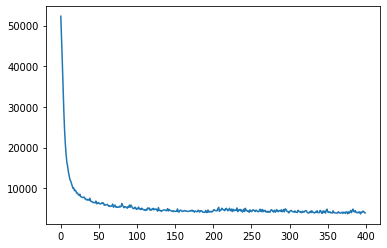

In [8]:
# Training
total_loss = []
def train(train_loader, loader_num):
    for epoch in range(1, 101):
        print("Training with Loader ", loader_num)
        model.train()
        train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data[:,0,:,:].to(device)
            data = data.view(-1, 3, 128, 128)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % 3 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(data)))
        average_loss = train_loss / len(train_loader.dataset)
        total_loss.append(average_loss)
        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, average_loss))

train(train_loader1, 1)
train(train_loader2, 2)
train(train_loader3, 3)
train(train_loader4, 4)

plt.plot(total_loss)
plt.xlabel = "Epochs"
plt.ylabel = "Average loss"
plt.show()

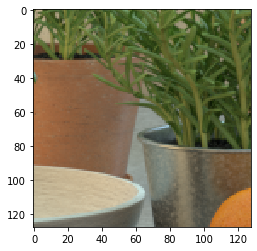

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


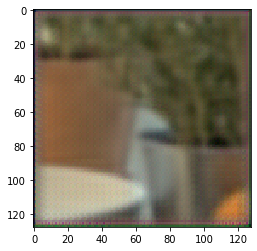

In [9]:
# Test and plot
from matplotlib import pyplot
import numpy as np

model.eval()
h_views, v_views, i_views, d_views, center, gt, mask, index = test_set.get_scene(0)
test_data = torch.tensor(h_views, device=device).float()
img,_,_ = model(test_data.view(-1, 3, 128, 128))
img = img.cpu().detach().numpy()[0]
img = np.stack((img[0], img[1], img[2]), axis=-1)
gt = test_data.cpu().detach().numpy()[0]
gt = np.stack((gt[0], gt[1], gt[2]), axis=-1)
plt.imshow(gt)
plt.show()
plt.imshow(img)
plt.savefig('/home/kollasfa/test.png')
plt.show()